<a href="https://colab.research.google.com/github/roni762583/181-Multivariate_time_series_forecasting_using_LSTM/blob/main/181_Multivariate_time_series_forecasting_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ref. https://www.youtube.com/watch?v=tepxdcepTbY&feature=youtu.be
# from: https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#clone data
! git clone https://github.com/roni762583/181-Multivariate_time_series_forecasting_using_LSTM/
df = pd.read_csv("181-Multivariate_time_series_forecasting_using_LSTM/GE.csv")
print(df.head())

Cloning into '181-Multivariate_time_series_forecasting_using_LSTM'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
         Date  Open  High   Low  Close  Adj Close     Volume
0  2020-11-04  7.69  8.02  7.53   7.85   7.842785  126925100
1  2020-11-05  7.95  8.05  7.91   7.99   7.982656   85806800
2  2020-11-06  8.02  8.14  7.96   8.09   8.082564   84125500
3  2020-11-09  9.35  9.41  8.61   8.72   8.711986  193282700
4  2020-11-10  8.82  9.10  8.75   8.98   8.971746  164733600


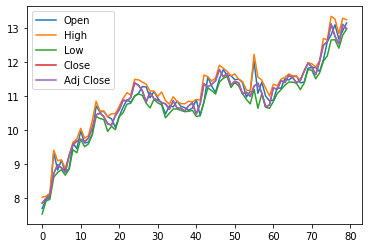

In [12]:

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = list(df)[1:6]

df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()


In [13]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))




trainX shape == (66, 14, 5).
trainY shape == (66, 1).


In [14]:
# define LSTM model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2)) # may not be relevant here
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
4/4 [==============================] - 2s 132ms/step - loss: 0.2488 - val_loss: 2.6568
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 0.1998 - val_loss: 2.1666
Epoch 3/10
4/4 [==============================] - 0s 25ms/step - loss: 0.1463 - val_loss: 1.5604
Epoch 4/10
4/4 [==============================] - 0s 25ms/step - loss: 0.1164 - val_loss: 0.8377
Epoch 5/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0998 - val_loss: 0.3049
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 0.1063 - val_loss: 0.2373
Epoch 7/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0820 - val_loss: 0.2346
Epoch 8/10
4/4 [==============================] - 0s 27ms/step - loss: 0.1015 - val_loss: 0.3219
Epoch 9/10
4/4 [==============================] - 0s 26ms/step - loss: 0.0944 - val_loss: 0.3312
Epoch 10/10
4/4 [==============================] - 0s 25ms/step - loss: 0.1091 - val_loss: 0.3117


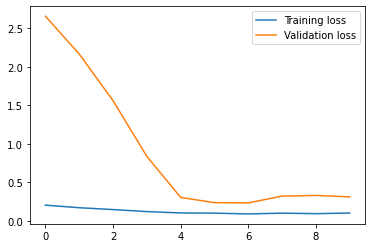

In [15]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [16]:
#Forecasting...
#Start with the last day in training date and predict future...
# n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates... # THIS CAUSED SHAPE ERROR BETWEEN X AND Y ON NEXT CELL
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [17]:
'''
print(len(np.array(forecast_dates)))
print(np.array(forecast_dates))

print(len((y_pred_future)))
print((y_pred_future))
'''
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


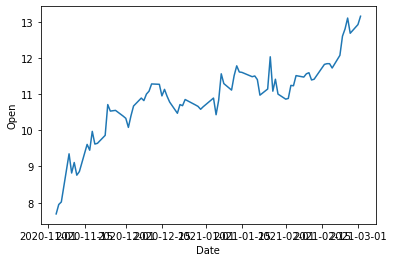

In [18]:
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])